# Google Store revenue prediction

In this notebook we will be exploring the Google Store dataset from Kaggle, and attempt to predict a customer's total revenue. First, some setup:

In [1]:
#imports
import pandas as pd
import numpy as np
import os
import json
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import lightgbm as lgb
import seaborn as sns
import datetime
import squarify
import plotly.offline as py
py.init_notebook_mode(connected=True)

color = sns.color_palette()

%matplotlib inline

from sklearn.model_selection import train_test_split
from scipy.stats import kurtosis, skew # it's to explore some statistics of numerical values
from plotly import tools
from pandas import json_normalize
from sklearn import model_selection, preprocessing, metrics

# Importing librarys to use on interactive graphs
from plotly.offline import init_notebook_mode, iplot, plot 
import plotly.graph_objs as go 

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

# Loads the data and flattens the JSON features. Taken from https://www.kaggle.com/sudalairajkumar/simple-exploration-baseline-ga-customer-revenue
def load_df(csv_path='data/train.csv', nrows=100000):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}, # Important!!
                     nrows=nrows)
    
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
    return df

Next, we need to load the data:

In [2]:
%%time
train_fresh = load_df()
test_fresh = load_df("data/test.csv")
pd.set_option('display.max_columns', None)

train = train_fresh.copy()
test = test_fresh.copy()

Loaded train.csv. Shape: (100000, 55)
Loaded test.csv. Shape: (100000, 53)
Wall time: 33.7 s


## Exploring the data
A lot of this is inspired by and taken from https://www.kaggle.com/kabure/exploring-the-consumer-patterns-ml-pipeline/data due to the fact that this dataset is highly complex and, at least to us, difficult to work with and analyze. 

seeing if our data is missing any values

In [3]:
def missing_values(data):
    total = data.isnull().sum().sort_values(ascending = False) # getting the sum of null values and ordering
    percent = (data.isnull().sum() / data.isnull().count() * 100 ).sort_values(ascending = False) #getting the percent and order of null
    df = pd.concat([total, percent], axis=1, keys=['Total', 'Percent']) # Concatenating the total and percent
    print("Total columns at least one Values: ")
    print (df[~(df['Total'] == 0)]) # Returning values of nulls different of 0
    
    print("\n Total of Sales % of Total: ", round((train[train['totals.transactionRevenue'] != np.nan]['totals.transactionRevenue'].count() / len(train['totals.transactionRevenue']) * 100),4))
    
    return 

In [4]:
missing_values(train)

Total columns at least one Values: 
                                              Total  Percent
trafficSource.campaignCode                    99999   99.999
trafficSource.adContent                       98675   98.675
totals.transactionRevenue                     98601   98.601
trafficSource.adwordsClickInfo.isVideoAd      97426   97.426
trafficSource.adwordsClickInfo.adNetworkType  97426   97.426
trafficSource.adwordsClickInfo.slot           97426   97.426
trafficSource.adwordsClickInfo.page           97426   97.426
trafficSource.adwordsClickInfo.gclId          97375   97.375
trafficSource.isTrueDirect                    69546   69.546
trafficSource.referralPath                    63527   63.527
trafficSource.keyword                         55782   55.782
totals.bounces                                51084   51.084
totals.newVisits                              22737   22.737
totals.pageviews                                  7    0.007

 Total of Sales % of Total:  1.399


Our target have just 1.3% of non-null values
8 columns with 97%+ of missing values
4 columns with 50%+ of missing values
1 column with 22.19%
1 column with 0.011%

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 55 columns):
 #   Column                                             Non-Null Count   Dtype 
---  ------                                             --------------   ----- 
 0   channelGrouping                                    100000 non-null  object
 1   date                                               100000 non-null  int64 
 2   fullVisitorId                                      100000 non-null  object
 3   sessionId                                          100000 non-null  object
 4   socialEngagementType                               100000 non-null  object
 5   visitId                                            100000 non-null  int64 
 6   visitNumber                                        100000 non-null  int64 
 7   visitStartTime                                     100000 non-null  int64 
 8   device.browser                                     100000 non-null  object
 9   devic

Lets see how many unique visitors we have in train and test set, and the number of common visitors

In [6]:
print("Number of unique visitors in train set : ",train.fullVisitorId.nunique(), " out of rows : ",train.shape[0])
print("Number of unique visitors in test set : ",test.fullVisitorId.nunique(), " out of rows : ",test.shape[0])
print("Number of common visitors in train and test set : ",len(set(train.fullVisitorId.unique()).intersection(set(test.fullVisitorId.unique())) ))

Number of unique visitors in train set :  89213  out of rows :  100000
Number of unique visitors in test set :  88041  out of rows :  100000
Number of common visitors in train and test set :  349


TODO: Maybe remove/replace

In [7]:
# Find the columns where values are not available
useless_cols = [col for col in train.columns if train[col].eq("not available in demo dataset").all()]
# Drop these columns from the dataframe
train.drop(useless_cols,
        axis=1,
        inplace=True)

# Find the columns where values are not available
useless_cols = [col for col in train.columns if train[col].isna().all()]
# Drop these columns from the dataframe
train.drop(useless_cols,
        axis=1,
        inplace=True)

C:\Users\steff\anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:253: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



In [8]:
const_cols = [c for c in train.columns if train[c].nunique(dropna=False)==1 ]
const_cols

['socialEngagementType', 'totals.visits']

Lets look at variable names found in train dataset but not in test dataset

In [9]:
print("Variables not in test but in train : ", set(train.columns).difference(set(test.columns)))

Variables not in test but in train :  {'trafficSource.campaignCode', 'totals.transactionRevenue'}


We see that apart from our target "totals.transactionRevenue" there is the variable "trafficSource.campaignCode" not present in test dataset. This needs to be removed. We also drop the constant variables we got earlier. "sessionId" will also be removed seeing as it is a unique identifier of the visit.

In [10]:
cols_to_drop = const_cols + ['sessionId']

train_df = train.drop(cols_to_drop + ["trafficSource.campaignCode"], axis=1)
#train_df = train.drop(cols_to_drop, axis=1)
test_df = test.drop(cols_to_drop, axis=1)

In [11]:
train_df.shape

(100000, 34)

In [12]:
train_df.nunique()

channelGrouping                                     8
date                                               40
fullVisitorId                                   89213
visitId                                         98121
visitNumber                                       223
visitStartTime                                  98123
device.browser                                     29
device.operatingSystem                             16
device.isMobile                                     2
device.deviceCategory                               3
geoNetwork.continent                                6
geoNetwork.subContinent                            23
geoNetwork.country                                183
geoNetwork.region                                 218
geoNetwork.metro                                   53
geoNetwork.city                                   290
geoNetwork.networkDomain                         7228
totals.hits                                       165
totals.pageviews            

#### Find kurtosis and Skewness of Transaction Revenue

In [13]:
pd.DataFrame(train.skew(),columns=["totals.transactionRevenue"])

,totals.transactionRevenue
date,0.165344
fullVisitorId,0.173518
sessionId,0.173518
visitId,0.258577
visitNumber,19.161959
visitStartTime,0.258577
device.isMobile,1.102698
totals.visits,0.000000
totals.hits,9.970617
totals.pageviews,9.056392


In [14]:
pd.DataFrame(train.kurt(),columns=["totals.transactionRevenue"])

,totals.transactionRevenue
date,-1.967244
fullVisitorId,-0.509900
sessionId,-0.509900
visitId,-1.177327
visitNumber,464.222545
visitStartTime,-1.177327
device.isMobile,-0.784072
totals.visits,0.000000
totals.hits,248.448182
totals.pageviews,229.658284


In [15]:
def scatter_plot(cnt_srs, color):
    trace = go.Scatter(
        x=cnt_srs.index[::-1],
        y=cnt_srs.values[::-1],
        showlegend=False,
        marker=dict(
            color=color,
        ),
    )
    return trace

train_df['date'] = train_df['date'].apply(lambda x: datetime.date(int(str(x)[:4]), int(str(x)[4:6]), int(str(x)[6:])))
cnt_srs = train_df.groupby('date')['totals.transactionRevenue'].agg(['size', 'count'])
cnt_srs.columns = ["count", "count of non-zero revenue"]
cnt_srs = cnt_srs.sort_index()
#cnt_srs.index = cnt_srs.index.astype('str')
trace1 = scatter_plot(cnt_srs["count"], 'red')
#trace2 = scatter_plot(cnt_srs["count of non-zero revenue"], 'blue')

fig = tools.make_subplots(rows=2, cols=1, vertical_spacing=0.08,
                          subplot_titles=["Date - Count", "Date - Non-zero Revenue count"])
fig.append_trace(trace1, 1, 1)
#fig.append_trace(trace2, 2, 1)
fig['layout'].update(height=400, width=800, paper_bgcolor='rgb(233,233,233)', title="Date Plots")
py.iplot(fig, filename='date-plots')

C:\Users\steff\anaconda3\lib\site-packages\plotly\tools.py:461: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



We have data from 1 Aug, 2016 to 31 July, 2017 in our training dataset
In Nov 2016, though there is an increase in the count of visitors, there is 
no increase in non-zero revenue counts during that time period(relative to the mean).

In [16]:
test_df['date'] = test_df['date'].apply(lambda x: datetime.date(int(str(x)[:4]), int(str(x)[4:6]), int(str(x)[6:])))
cnt_srs = test_df.groupby('date')['fullVisitorId'].size()


trace = scatter_plot(cnt_srs, 'red')

layout = go.Layout(
    height=400,
    width=800,
    paper_bgcolor='rgb(233,233,233)',
    title='Dates in Test set'
)

data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="ActivationDate")

In the test set, we have dates from 2 Aug, 2017 to 30 Apr, 2018. So there are no common dates between train and test set. So it might be a good idea to do time based validation for this dataset.

### Device Browser

Percentual of Browser usage: 
Chrome               68984
Safari               20467
Firefox               4004
Internet Explorer     2080
Edge                  1063
Safari (in-app)        743
Android Webview        715
Name: device.browser, dtype: int64


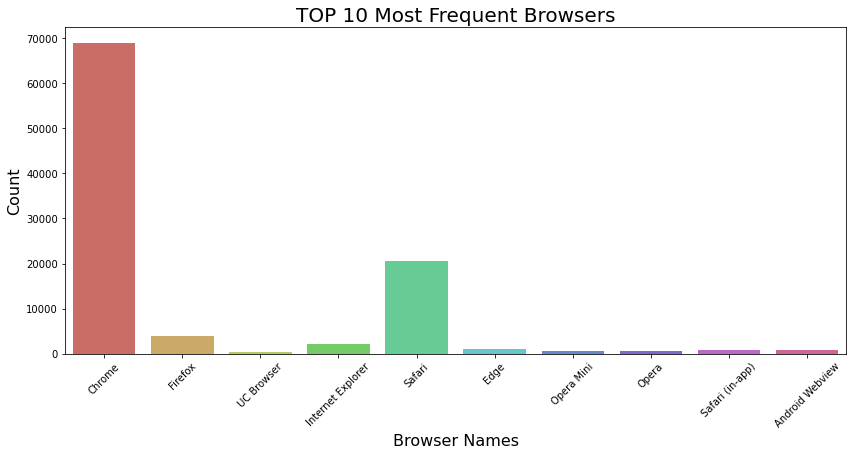

In [17]:
# the top 10 of browsers represent % of total
print("Percentual of Browser usage: ")
print(train_df['device.browser'].value_counts()[:7] ) # printing the top 7 percentage of browsers

# seting the graph size
plt.figure(figsize=(14,6))

# Let explore the browser used by users
sns.countplot(train_df[train_df['device.browser']\
                       .isin(train_df['device.browser']\
                             .value_counts()[:10].index.values)]['device.browser'], palette="hls") # It's a module to count the category's
plt.title("TOP 10 Most Frequent Browsers", fontsize=20) # Adding Title and seting the size
plt.xlabel("Browser Names", fontsize=16) # Adding x label and seting the size
plt.ylabel("Count", fontsize=16) # Adding y label and seting the size
plt.xticks(rotation=45) # Adjust the xticks, rotating the labels

plt.show() #use plt.show to render the graph that we did above

Percentual of Operational System: 
Windows      38001
Macintosh    29089
Android      13323
iOS          11718
Linux         4114
Name: device.operatingSystem, dtype: int64


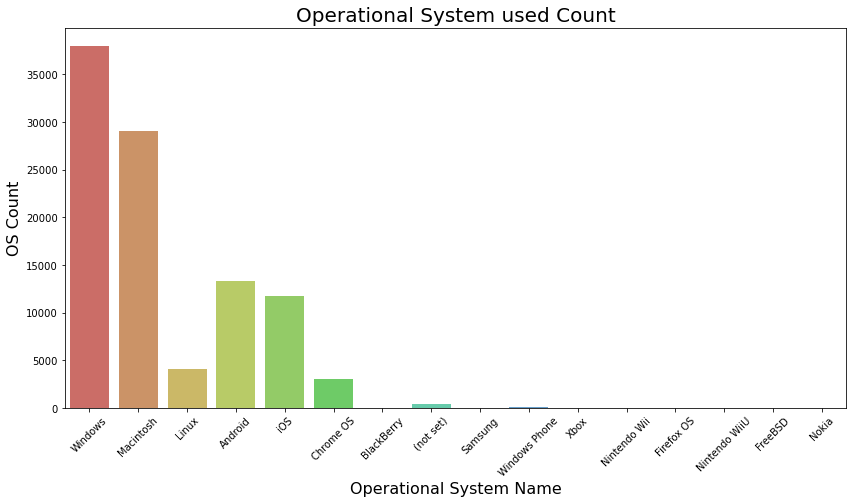

In [18]:
# the top 5 of browsers represent % of total
print("Percentual of Operational System: ")
print(train_df['device.operatingSystem'].value_counts()[:5]) # printing the top 7 percentage of browsers

# seting the graph size
plt.figure(figsize=(14,7))

# let explore the browser used by users
sns.countplot(train_df["device.operatingSystem"], palette="hls") # It's a module to count the category's
plt.title("Operational System used Count", fontsize=20) # seting the title size
plt.xlabel("Operational System Name", fontsize=16) # seting the x label size
plt.ylabel("OS Count", fontsize=16) # seting the y label size
plt.xticks(rotation=45) # Adjust the xticks, rotating the labels

plt.show() #use plt.show to render the graph that we did above

### Geographic information

Description of SubContinent count: 
Northern America    43874
Southeast Asia       9212
Western Europe       6481
Southern Asia        6331
Northern Europe      6172
Eastern Europe       5212
Eastern Asia         4815
South America        4549
Name: geoNetwork.subContinent, dtype: int64


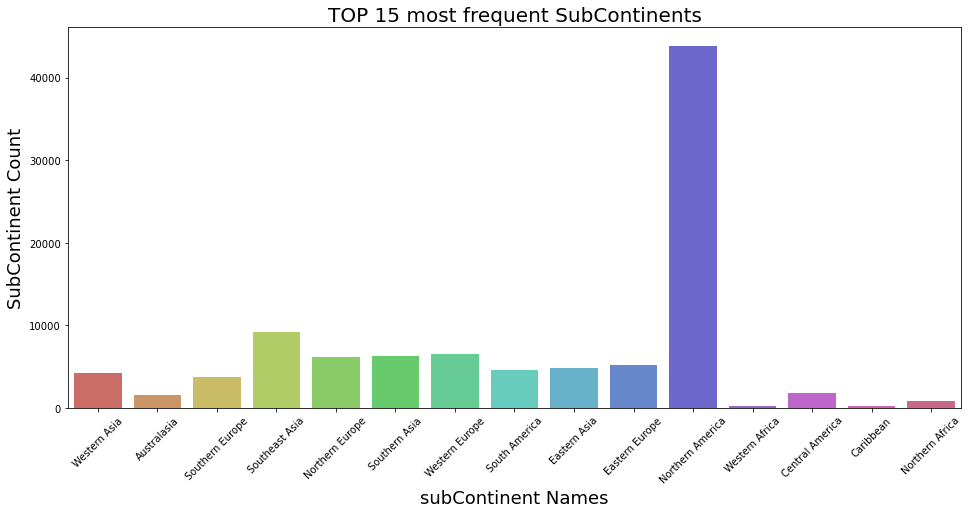

In [19]:
# the top 8 of browsers represent % of total
print("Description of SubContinent count: ")
print(train_df['geoNetwork.subContinent'].value_counts()[:8]) # printing the top 7 percentage of browsers

# seting the graph size
plt.figure(figsize=(16,7))

# let explore the browser used by users
sns.countplot(train_df[train_df['geoNetwork.subContinent']\
                       .isin(train_df['geoNetwork.subContinent']\
                             .value_counts()[:15].index.values)]['geoNetwork.subContinent'], palette="hls") # It's a module to count the category's
plt.title("TOP 15 most frequent SubContinents", fontsize=20) # seting the title size
plt.xlabel("subContinent Names", fontsize=18) # seting the x label size
plt.ylabel("SubContinent Count", fontsize=18) # seting the y label size
plt.xticks(rotation=45) # Adjust the xticks, rotating the labels

plt.show() #use plt.show to render the graph that we did above

Description most frequent countrys: 
United States     40939
India              5499
United Kingdom     4092
Vietnam            3114
Canada             2930
Turkey             2314
Thailand           2309
Brazil             2231
Germany            2133
Japan              2091
France             1806
Mexico             1522
Australia          1358
Netherlands        1297
Taiwan             1295
Name: geoNetwork.country, dtype: int64


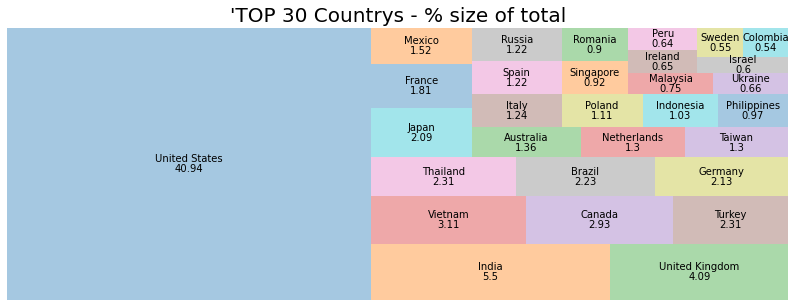

In [20]:
country_tree = train_df["geoNetwork.country"].value_counts() #counting the values of Country

print("Description most frequent countrys: ")
print(country_tree[:15]) #printing the 15 top most 

country_tree = round((train_df["geoNetwork.country"].value_counts()[:30] \
                       / len(train_df['geoNetwork.country']) * 100),2)

plt.figure(figsize=(14,5))
g = squarify.plot(sizes=country_tree.values, label=country_tree.index, 
                  value=country_tree.values,
                  alpha=.4, color=color)
g.set_title("'TOP 30 Countrys - % size of total",fontsize=20)
g.set_axis_off()
plt.show()

### Paying Customers

In [21]:
payingCustomers = train_df.loc[train_df['totals.transactionRevenue'].notna()]
payingCustomers
payingCustomers["fullVisitorId"]

752      6194193421514403509
753      5327166854580374902
799      8885051388942907862
802      0185467632009737931
859      3244885836845029978
                ...         
99729    3590222967147519334
99730    6781934558737955524
99733    5976063913493194585
99736    1710276641442998015
99743    1884511874414753238
Name: fullVisitorId, Length: 1399, dtype: object

In [22]:
payingCustomers.describe()

,visitId,visitNumber,visitStartTime
count,1.399000e+03,1399.000000,1.399000e+03
mean,1.485392e+09,3.887777,1.485392e+09
std,9.379675e+06,10.389323,9.379678e+06
min,1.470908e+09,1.000000,1.470908e+09
25%,1.479507e+09,1.000000,1.479507e+09
50%,1.481930e+09,2.000000,1.481930e+09
75%,1.494876e+09,4.000000,1.494876e+09
max,1.501652e+09,315.000000,1.501652e+09


In [23]:
payingCustomers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1399 entries, 752 to 99743
Data columns (total 34 columns):
 #   Column                                        Non-Null Count  Dtype 
---  ------                                        --------------  ----- 
 0   channelGrouping                               1399 non-null   object
 1   date                                          1399 non-null   object
 2   fullVisitorId                                 1399 non-null   object
 3   visitId                                       1399 non-null   int64 
 4   visitNumber                                   1399 non-null   int64 
 5   visitStartTime                                1399 non-null   int64 
 6   device.browser                                1399 non-null   object
 7   device.operatingSystem                        1399 non-null   object
 8   device.isMobile                               1399 non-null   bool  
 9   device.deviceCategory                         1399 non-null   object
 1

## Transformers

We were going to make this awesome pipeline but we never got to it

#### Transformer for removing unwanted features

In [24]:
from sklearn.base import TransformerMixin
from sklearn.base import BaseEstimator

class FeatureReducer(BaseEstimator, TransformerMixin):
    def __init__(self, features):
        self.features = features
    
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X.drop(self.features, axis=1)

#### Transformers for labeling, converting and imputing the data

In [25]:
class Labeler(BaseEstimator, TransformerMixin):
    def __init__(self, cat_cols):
        self.cat_cols = cat_cols
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        for col in self.cat_cols:
            lbl = preprocessing.LabelEncoder()
            lbl.fit(list(X[col].values.astype('str')))
            X[col] = lbl.transform(list(X[col].values.astype('str')))
        return X

class Floatinator(BaseEstimator, TransformerMixin):
    def __init__(self, num_cols):
        self.num_cols = num_cols
    
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        for col in self.num_cols:
            X[col] = X[col].astype(float)
        return X
    
class SimplerImputer(BaseEstimator, TransformerMixin):
    def __init__(self, cols):
        self.cols = cols
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        for col in self.cols:
            X[col].fillna(0.0, inplace=True)
        return X


## Collect all columns which need to be dropped

In [26]:
train = train_fresh.copy()
test = test_fresh.copy()

useless_cols = [col for col in train.columns 
                if train[col].isna().all() 
                or train[col].eq("not available in demo dataset").all()
                or train[col].nunique(dropna=False)==1]
useless_cols = useless_cols + ["trafficSource.campaignCode"] + ["sessionId"]
useless_cols

C:\Users\steff\anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:253: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



['socialEngagementType',
 'device.browserVersion',
 'device.browserSize',
 'device.operatingSystemVersion',
 'device.mobileDeviceBranding',
 'device.mobileDeviceModel',
 'device.mobileInputSelector',
 'device.mobileDeviceInfo',
 'device.mobileDeviceMarketingName',
 'device.flashVersion',
 'device.language',
 'device.screenColors',
 'device.screenResolution',
 'geoNetwork.cityId',
 'geoNetwork.latitude',
 'geoNetwork.longitude',
 'geoNetwork.networkLocation',
 'totals.visits',
 'trafficSource.adwordsClickInfo.criteriaParameters',
 'trafficSource.campaignCode',
 'sessionId']

#### Declare categorical columns

In [27]:
cat_cols = ["channelGrouping", "device.browser", 
            "device.deviceCategory", "device.operatingSystem", 
            "geoNetwork.city", "geoNetwork.continent", 
            "geoNetwork.country", "geoNetwork.metro",
            "geoNetwork.networkDomain", "geoNetwork.region", 
            "geoNetwork.subContinent", "trafficSource.adContent", 
            "trafficSource.adwordsClickInfo.adNetworkType", 
            "trafficSource.adwordsClickInfo.gclId", 
            "trafficSource.adwordsClickInfo.page", 
            "trafficSource.adwordsClickInfo.slot", "trafficSource.campaign",
            "trafficSource.keyword", "trafficSource.medium", 
            "trafficSource.referralPath", "trafficSource.source",
            'trafficSource.adwordsClickInfo.isVideoAd', 'trafficSource.isTrueDirect']

### Declare numerical columns

In [28]:
num_cols = ["totals.hits", "totals.pageviews", "visitNumber", "visitStartTime", 'totals.bounces',  'totals.newVisits']

### Imports

In [29]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

In [30]:
for col in cat_cols:
    print(col)
    lbl = preprocessing.LabelEncoder()
    lbl.fit(list(train[col].values.astype('str')) + list(test[col].values.astype('str')))
    train[col] = lbl.transform(list(train[col].values.astype('str')))
    test[col] = lbl.transform(list(test[col].values.astype('str')))

channelGrouping
device.browser
device.deviceCategory
device.operatingSystem
geoNetwork.city
geoNetwork.continent
geoNetwork.country
geoNetwork.metro
geoNetwork.networkDomain
geoNetwork.region
geoNetwork.subContinent
trafficSource.adContent
trafficSource.adwordsClickInfo.adNetworkType
trafficSource.adwordsClickInfo.gclId
trafficSource.adwordsClickInfo.page
trafficSource.adwordsClickInfo.slot
trafficSource.campaign
trafficSource.keyword
trafficSource.medium
trafficSource.referralPath
trafficSource.source
trafficSource.adwordsClickInfo.isVideoAd
trafficSource.isTrueDirect


In [31]:
"""label_encoding_pipeline = Pipeline([
    ("encode_labels", ColumnTransformer(
        ("label_transformer", LabelEncoder(), categorical_cols)
    ))
])"""

full_pipeline = Pipeline([
    ("impute_revenue", ColumnTransformer(
        ('revenue_imputer', SimpleImputer(strategy="constant", fill_value=0), "totals.transactionRevenue")
    )),
    ('reduce', FeatureReducer(useless_cols)),
    ("encode_labels", ColumnTransformer(
        ("label_transformer", LabelEncoder(), cat_cols)
    ))
])

"""
train_pipeline = Pipeline([
    full_pipeline,
    ("impute_revenue", ColumnTransformer([
        ('revenue_imputer', SimpleImputer(strategy="constant", fill_value=0), "totals.transactionRevenue")
    ]))
])"""

'\ntrain_pipeline = Pipeline([\n    full_pipeline,\n    ("impute_revenue", ColumnTransformer([\n        (\'revenue_imputer\', SimpleImputer(strategy="constant", fill_value=0), "totals.transactionRevenue")\n    ]))\n])'

## Preprocess data for training

In [32]:
# Remove useless columns
train = FeatureReducer(useless_cols).transform(train)

In [33]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 34 columns):
 #   Column                                        Non-Null Count   Dtype 
---  ------                                        --------------   ----- 
 0   channelGrouping                               100000 non-null  int64 
 1   date                                          100000 non-null  int64 
 2   fullVisitorId                                 100000 non-null  object
 3   visitId                                       100000 non-null  int64 
 4   visitNumber                                   100000 non-null  int64 
 5   visitStartTime                                100000 non-null  int64 
 6   device.browser                                100000 non-null  int64 
 7   device.operatingSystem                        100000 non-null  int64 
 8   device.isMobile                               100000 non-null  bool  
 9   device.deviceCategory                         100000 non-nul

In [34]:
# Impute values
cols_to_impute = [
    "totals.transactionRevenue",
    "totals.pageviews",
    "totals.bounces",
    "totals.newVisits"
]
train = SimplerImputer(cols_to_impute).transform(train)

In [35]:
train = Labeler(cat_cols).transform(train)

In [36]:
train = Floatinator(num_cols).transform(train)

In [37]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 34 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   channelGrouping                               100000 non-null  int64  
 1   date                                          100000 non-null  int64  
 2   fullVisitorId                                 100000 non-null  object 
 3   visitId                                       100000 non-null  int64  
 4   visitNumber                                   100000 non-null  float64
 5   visitStartTime                                100000 non-null  float64
 6   device.browser                                100000 non-null  int64  
 7   device.operatingSystem                        100000 non-null  int64  
 8   device.isMobile                               100000 non-null  bool   
 9   device.deviceCategory                         100

In [38]:
train.head()

,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,device.browser,device.operatingSystem,device.isMobile,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.networkDomain,totals.hits,totals.pageviews,totals.bounces,totals.newVisits,totals.transactionRevenue,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword,trafficSource.isTrueDirect,trafficSource.referralPath,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adContent
0,4,20160902,1131660440785968503,1472830385,1.0,1.472830e+09,1,5,False,0,3,14,84,26,0,60,153,1.0,1.0,1.0,1.0,0,3,142,5,314,1,138,4,2,2361,2,1,21
1,4,20160902,377306020877927890,1472880147,1.0,1.472880e+09,4,14,False,0,5,1,172,163,51,249,2261,1.0,1.0,1.0,1.0,0,3,142,5,314,1,138,4,2,2361,2,1,21
2,4,20160902,3895546263509774583,1472865386,1.0,1.472865e+09,1,5,False,0,4,11,65,194,0,91,423,1.0,1.0,1.0,1.0,0,3,142,5,314,1,138,4,2,2361,2,1,21
3,4,20160902,4763447161404445595,1472881213,1.0,1.472881e+09,22,13,False,0,3,8,164,163,51,249,423,1.0,1.0,1.0,1.0,0,3,142,5,141,1,138,4,2,2361,2,1,21
4,4,20160902,27294437909732085,1472822600,2.0,1.472823e+09,1,1,True,1,4,5,90,163,51,249,423,1.0,1.0,1.0,0.0,0,3,142,5,314,0,138,4,2,2361,2,1,21


## Split data

In [39]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    train, 
    train["totals.transactionRevenue"], test_size=0.4, random_state=42)

In [40]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60000 entries, 40507 to 15795
Data columns (total 34 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   channelGrouping                               60000 non-null  int64  
 1   date                                          60000 non-null  int64  
 2   fullVisitorId                                 60000 non-null  object 
 3   visitId                                       60000 non-null  int64  
 4   visitNumber                                   60000 non-null  float64
 5   visitStartTime                                60000 non-null  float64
 6   device.browser                                60000 non-null  int64  
 7   device.operatingSystem                        60000 non-null  int64  
 8   device.isMobile                               60000 non-null  bool   
 9   device.deviceCategory                         60000 non-n

In [41]:
y_train.head()

40507    0
72707    0
90912    0
28532    0
13006    0
Name: totals.transactionRevenue, dtype: object

In [42]:
y_test.describe()

count     40000.0
unique      452.0
top           0.0
freq      39430.0
Name: totals.transactionRevenue, dtype: float64

In [43]:
print("Variables not in test but in train : ", set(X_train.columns).difference(set(X_test.columns)))

Variables not in test but in train :  set()


In [44]:
from sklearn.ensemble import GradientBoostingRegressor

X_train = X_train.drop('totals.transactionRevenue', axis=1)
gbr = GradientBoostingRegressor(random_state=0)
gbr.fit(X_train, y_train)
gbr.score(X_test.drop('totals.transactionRevenue', axis=1), y_test)

-0.7584070722584437

## Storing the trained model

In [45]:
from joblib import dump

dump(gbr, "estimator.joblib")

['estimator.joblib']

## Deploying the model
At this point, we set up our server and move the joblib file to the server folder before deploying the server. The next step is to make sure our server actually works. To do this, we simply send some test data and see if the response is as expected. The code for our server can be found in the server folder. It is deployed and live on Heroku at https://hvl-dat158-ml2.herokuapp.com/

Since we have made our model available online we assume that we do not need to record a video of our model in action. You can also see the server working in the snippet below.

In [46]:
import requests
import json
 
json_data = X_test.head().drop("totals.transactionRevenue", axis=1).to_json()
headers = {'Content-type': 'application/json'}
url = "https://hvl-dat158-ml2.herokuapp.com/"

req = requests.post(url, data=json_data, headers=headers)
preds = req.json()
preds_df = pd.DataFrame(preds)
preds_df

,fullVisitorId,predictedRevenue
75721,3931197784614007060,0.000000
80184,2878042683639005958,328757.924985
19864,9730407490352447996,0.000000
76699,721487069151965948,111343.136364
92991,2805216281702837802,0.000000


We looked at various deployment alternatives and decided Heroku seemed like the most practical candidate. 